In [99]:
import tempfile
import pickle as pkl
from pathlib import Path
import os
import yaml

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer

import mlflow
import dvc.api

from bayes_opt import BayesianOptimization
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import GPT2Tokenizer

import shap

from auxiliar import crear_ensemble_donadas

In [100]:
# Paramètres
with open("config.yml", "r", encoding="utf-8") as file:
    config = yaml.safe_load(file)

VERSION_DONADAS = config["parametres"]["version_donadas"]
LONGOR_MIN = int(config["parametres"]["longor_min"])
LONGOR_MAX = config["parametres"]["longor_max"]
if LONGOR_MAX == "inf":
    LONGOR_MAX = np.inf
TALHA_TEST = config["parametres"]["talha_test"]
ESTAT_ALEATORI = int(config["parametres"]["estat_aleatori"])

INPUT_FICHIER_WIKI_TEXTE = config["camins"]["texte"]["fichier_wiki_texte"]

if VERSION_DONADAS is not None:
    INPUT_FICHER_WIKI_ETIQUETAS_ALEATORI = dvc.api.get_url(
        config["camins"]["etiquetas"]["fichier_wiki_etiquetas_aleatori"], rev=VERSION_DONADAS
    )
    INPUT_FICHER_WIKI_ETIQUETAS_AUTOMATIC = dvc.api.get_url(
        config["camins"]["etiquetas"]["fichier_wiki_etiquetas_automatic"], rev=VERSION_DONADAS
    )
    INPUT_FICHER_WIKI_ETIQUETAS_ENTROPIA = dvc.api.get_url(
        config["camins"]["etiquetas"]["fichier_wiki_etiquetas_entropia"], rev=VERSION_DONADAS
    )
else:
    INPUT_FICHER_WIKI_ETIQUETAS_ALEATORI = config["camins"]["etiquetas"]["fichier_wiki_etiquetas_aleatori"]
    INPUT_FICHER_WIKI_ETIQUETAS_AUTOMATIC = config["camins"]["etiquetas"]["fichier_wiki_etiquetas_automatic"]
    INPUT_FICHER_WIKI_ETIQUETAS_ENTROPIA = config["camins"]["etiquetas"]["fichier_wiki_etiquetas_entropia"]

INPUT_DOSSIER_TOKENIZAIRE = config["camins"]["tokenizaire"]["dossier_tokenizaire"]

OUTPUT_PREDICCIONS = config["camins"]["classificador"]["xgboost"]["prediccions"]
OUTPUT_SELECCION_PAGINAS = config["camins"]["classificador"]["xgboost"]["seleccion_paginas"]
OUTPUT_DOSSIER_MODEL = config["camins"]["classificador"]["xgboost"]["dossier_model"]

OPTIMIZACION_BAYESIANA = False

In [101]:
texte_df = pd.read_csv(INPUT_FICHIER_WIKI_TEXTE)
longor_texte = texte_df["Texte"].apply(len)
texte_df = texte_df[(longor_texte > LONGOR_MIN) & (longor_texte < LONGOR_MAX)].reset_index(drop=True)

dict_dialectes_df = {
    "aleatori": pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_ALEATORI),
    "entropia": pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_ENTROPIA),
    "automatic": pd.read_csv(INPUT_FICHER_WIKI_ETIQUETAS_AUTOMATIC),
}

texte_etiquetas_df = crear_ensemble_donadas(
    texte_df=texte_df,
    dict_dialectes_df=dict_dialectes_df,
)
texte_etiquetas_df

,Article,Dialecte,Texte
0,Vieux-Champagne,lengadocian,vieux-champagne es una situada dins lo de sèin...
1,Ereditat,lengadocian,lereditat (del latin hereditas çò que s'erita ...
2,White_Town,lengadocian,white town es un projècte britanic de musica e...
3,Puigverd_d'Agramunt,lengadocian,puigverd d'agramunt es un de la
4,La_Grande_Montagne,lengadocian,la grande montagne es una de sant bartomieu di...
...,...,...,...
8356,Roger_de_Flor,provençal,ruggero da fiore ò rutger von blum (vèrs 1267 ...
8357,Aurelian_(emperaire_roman),provençal,aurelian en latin: lucius domitius aurelianus ...
8358,Miranda_(Gers),gascon,miranda (mirande en ) qu'ei ua ancianas ?
8359,Lekunberri_(Baisha_Navarra),gascon,lekunberri (


In [102]:
metadata = {
    **{
        "version_donadas": VERSION_DONADAS,
        "md5_etiquetas_aleatori": INPUT_FICHER_WIKI_ETIQUETAS_ALEATORI.split("/")[-1],
        "md5_etiquetas_automatic": INPUT_FICHER_WIKI_ETIQUETAS_AUTOMATIC.split("/")[-1],
        "md5_etiquetas_entropia": INPUT_FICHER_WIKI_ETIQUETAS_ENTROPIA.split("/")[-1],
        "talha_test": TALHA_TEST,
        "longor_min": LONGOR_MIN,
        "longor_max": LONGOR_MAX,
        "optimizacion_bayesiana": OPTIMIZACION_BAYESIANA,
    },
    **{f"nrows_{k}": v.shape[0] for k, v in dict_dialectes_df.items()},
}
metadata

{'version_donadas': None,
 'md5_etiquetas_aleatori': 'wikipedia_dialectes_aleatori.csv',
 'md5_etiquetas_automatic': 'wikipedia_dialectes_automatic.csv',
 'md5_etiquetas_entropia': 'wikipedia_dialectes_entropia.csv',
 'talha_test': 0.2,
 'longor_min': 50,
 'longor_max': inf,
 'optimizacion_bayesiana': False,
 'nrows_aleatori': 624,
 'nrows_entropia': 115,
 'nrows_automatic': 8117}

In [103]:
texte_etiquetas_entrenament, texte_etiquetas_test = train_test_split(
    texte_etiquetas_df, test_size=TALHA_TEST, random_state=ESTAT_ALEATORI
)

In [104]:
# Crear sac a mots
tokenizaire = GPT2Tokenizer.from_pretrained(
    INPUT_DOSSIER_TOKENIZAIRE,
    do_lower_case=True,
)
tokens_entrenament = texte_etiquetas_entrenament["Texte"].apply(tokenizaire.tokenize).apply(lambda x: " ".join(x))
tokens_test = texte_etiquetas_test["Texte"].apply(tokenizaire.tokenize).apply(lambda x: " ".join(x))
tokens_tot = texte_df["Texte"].apply(tokenizaire.tokenize).apply(lambda x: " ".join(x))

vectorizador = CountVectorizer(min_df=30)
bow_entrenament = vectorizador.fit_transform(tokens_entrenament)
bow_test = vectorizador.transform(tokens_test)
bow_tot = vectorizador.transform(tokens_tot)

# Codificar los dialèctes
codificador_ordinal = OrdinalEncoder()
etiquetas_entrenament = codificador_ordinal.fit_transform(texte_etiquetas_entrenament[["Dialecte"]]).astype(int)
etiquetas_test = codificador_ordinal.transform(texte_etiquetas_test[["Dialecte"]]).astype(int)

In [105]:
melhor_params = {}
if OPTIMIZACION_BAYESIANA:

    def evaluar(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
        kf = KFold(n_splits=3)
        f1_scores = []

        for train_index, valid_index in kf.split(bow_entrenament):

            xgb = XGBClassifier(
                max_depth=int(max_depth),
                learning_rate=learning_rate,
                n_estimators=int(n_estimators),
                gamma=gamma,
                min_child_weight=min_child_weight,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
            )
            xgb.fit(
                bow_entrenament[train_index],
                etiquetas_entrenament[train_index],
                sample_weight=compute_sample_weight("balanced", etiquetas_entrenament[train_index]),
                verbose=False,
            )
            etiquetas_predichas = xgb.predict(bow_entrenament[valid_index])
            score = f1_score(etiquetas_entrenament[valid_index], etiquetas_predichas, average="macro")
            f1_scores.append(score)

        return np.mean(f1_scores)

    limits = {
        "max_depth": (3, 12),
        "learning_rate": (0.01, 0.5),
        "n_estimators": (50, 200),
        "gamma": (0, 0.5),
        "min_child_weight": (1, 10),
        "subsample": (0.5, 1),
        "colsample_bytree": (0.5, 1),
    }

    optimizaire = BayesianOptimization(f=evaluar, pbounds=limits, random_state=63, verbose=2)

    optimizaire.maximize(init_points=10, n_iter=20)

    melhor_params = optimizaire.max["params"]
    melhor_params["max_depth"] = int(melhor_params["max_depth"])
    melhor_params["n_estimators"] = int(melhor_params["n_estimators"])

Exactitud: 0.9270771069934249
Precision: 0.8043654262404262
Rappel: 0.8570534561627916
F1: 0.8233086393903731


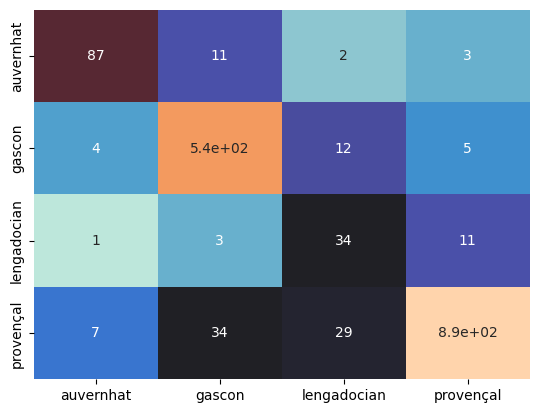

In [106]:
# Initialize MLflow
mlflow.set_experiment("XGBoost")
os.makedirs("mlruns", exist_ok=True)

# Start an MLflow run
with mlflow.start_run():

    # Entrenar e gardar lo darrièr model
    xgb_final = XGBClassifier(**melhor_params, random_state=ESTAT_ALEATORI)

    xgb_final.fit(
        bow_entrenament,
        etiquetas_entrenament,
        sample_weight=compute_sample_weight("balanced", etiquetas_entrenament),
    )
    mlflow.log_params(melhor_params)
    mlflow.log_params(metadata)

    # Predire e evaluar lo model
    y_pred_test = xgb_final.predict(bow_test).reshape(-1, 1)

    # Transformar las etiquetas numericas en etiquetas textualas
    dialecte_obs_test = codificador_ordinal.inverse_transform(etiquetas_test)
    dialecte_pred_test = codificador_ordinal.inverse_transform(y_pred_test)

    # Exactitud, Precision, Rappel, F1
    exactitud = accuracy_score(dialecte_obs_test, dialecte_pred_test)
    precision, rappel, f1, _ = precision_recall_fscore_support(
        dialecte_obs_test,
        dialecte_pred_test,
        average="macro",
    )
    print(f"Exactitud: {exactitud}\nPrecision: {precision}\nRappel: {rappel}\nF1: {f1}")
    mlflow.log_metric("exactitud", exactitud)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("rappel", rappel)
    mlflow.log_metric("f1", f1)

    # Matritz de confusion
    matritz_confusion = confusion_matrix(dialecte_obs_test, dialecte_pred_test)
    matritz_confusion_df = pd.DataFrame(
        matritz_confusion,
        index=codificador_ordinal.categories_[0],
        columns=codificador_ordinal.categories_[0],
    )
    fig = sns.heatmap(np.log(matritz_confusion_df + 1), annot=matritz_confusion_df, cbar=None, cmap="icefire")
    with tempfile.NamedTemporaryFile(suffix=".png") as temp_file:
        plt.savefig(temp_file.name)
        mlflow.log_artifact(temp_file.name, artifact_path="images")

In [107]:
with open(Path(OUTPUT_DOSSIER_MODEL) / Path("vectorizador.pkl"), "wb") as f:
    pkl.dump(vectorizador, f)

with open(Path(OUTPUT_DOSSIER_MODEL) / Path("codificador_ordinal.pkl"), "wb") as f:
    pkl.dump(codificador_ordinal, f)

with open(Path(OUTPUT_DOSSIER_MODEL) / Path("classificador.pkl"), "wb") as f:
    pkl.dump(xgb_final, f)

In [108]:
# Generar prediccions per totes los articles
y_pred_tot = xgb_final.predict(bow_tot).reshape(-1, 1)
y_prob_tot = xgb_final.predict_proba(bow_tot)
entropia_tot = np.sum(-y_prob_tot * np.log(y_prob_tot), axis=1)
resultats_df = pd.DataFrame(
    {
        "Article": texte_df["Article"],
        "Prediccion": codificador_ordinal.inverse_transform(y_pred_tot).reshape(-1),
        "Entropia": entropia_tot.reshape(-1),
    }
)
resultats_df = pd.concat(
    [resultats_df, pd.DataFrame(y_prob_tot, columns=codificador_ordinal.categories_[0])],
    axis=1,
)
resultats_df = resultats_df.merge(texte_etiquetas_df[["Article", "Dialecte"]], on="Article", how="left")
resultats_df.to_csv(OUTPUT_PREDICCIONS, index=False)
resultats_df.sort_values("Entropia", ascending=False)["Article"].to_csv(
    OUTPUT_SELECCION_PAGINAS, index=False, header=False
)
resultats_df.sort_values("Entropia", ascending=False)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
57465,Vitrac_de_Montana,auvernhat,1.382809,2.770712e-01,2.633806e-01,2.269058e-01,2.326423e-01,NaN
75914,Bòxa_pès-ponhs,lengadocian,1.381118,2.269031e-01,2.229179e-01,2.806976e-01,2.694814e-01,NaN
17930,EPITECH_European_Institute_of_Information_Tech...,provençal,1.380953,2.674328e-01,2.088067e-01,2.494096e-01,2.743509e-01,NaN
70328,Sent_Quentin_(Puèi_de_Doma),auvernhat,1.379539,2.954834e-01,2.183107e-01,2.547336e-01,2.314724e-01,NaN
1737,Valetas_(Agenés),lengadocian,1.376336,2.063263e-01,2.283268e-01,2.980486e-01,2.672983e-01,NaN
...,...,...,...,...,...,...,...,...
46532,Joan_Crisòstom,provençal,0.000047,2.793403e-07,9.901511e-07,1.990205e-06,9.999968e-01,provençal
28106,Calixte_III,provençal,0.000042,5.139847e-07,5.520712e-07,1.814605e-06,9.999971e-01,provençal
15202,Sent_Estève_de_Baigòrri,gascon,0.000038,5.343251e-07,9.999974e-01,1.662478e-06,4.093704e-07,gascon
46552,Ahraga_e_chocolat,gascon,0.000036,1.524629e-06,9.999975e-01,2.093829e-07,7.280313e-07,NaN


<Axes: xlabel='Prediccion', ylabel='Entropia'>

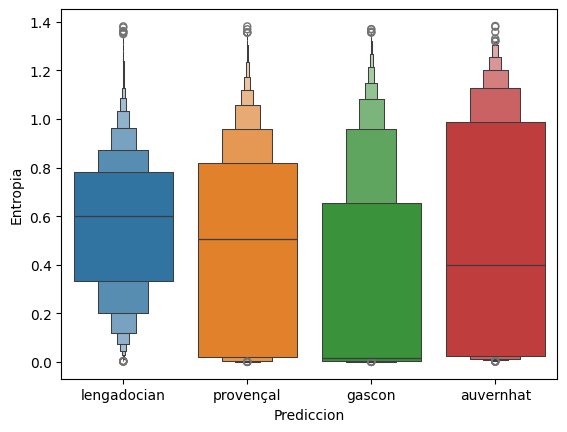

In [109]:
sns.boxenplot(data=resultats_df, x="Prediccion", y="Entropia", hue="Prediccion")

In [110]:
resultats_df.query('Dialecte.isnull() & Prediccion == "lengadocian"').sort_values("Entropia", ascending=False).head(20)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
75914,Bòxa_pès-ponhs,lengadocian,1.381118,0.226903,0.222918,0.280698,0.269481,NaN
1737,Valetas_(Agenés),lengadocian,1.376336,0.206326,0.228327,0.298049,0.267298,NaN
49287,Warao,lengadocian,1.361875,0.291922,0.225130,0.309648,0.173300,NaN
72690,Carlos_Polistico_Garcia,lengadocian,1.359873,0.278497,0.201841,0.330573,0.189090,NaN
16657,Abbàs_Ibn_Firnàs,lengadocian,1.358594,0.236968,0.220783,0.350927,0.191323,NaN
81051,Cemal_Gürsel,lengadocian,1.354377,0.243964,0.153421,0.310833,0.291783,NaN
6705,Joaquim_Chissano,lengadocian,1.348936,0.180138,0.190539,0.347244,0.282079,NaN
21106,Carles_lo_Calvet,lengadocian,1.347861,0.153971,0.234175,0.344402,0.267453,NaN
10306,Lo_Passatge,lengadocian,1.347631,0.154667,0.221894,0.335646,0.287793,NaN
46839,Koeur's,lengadocian,1.339918,0.167619,0.290050,0.354786,0.187545,NaN


In [111]:
resultats_df.query('Dialecte.isnull() & Prediccion == "auvernhat"').sort_values("Entropia", ascending=False).tail(20)

,Article,Prediccion,Entropia,auvernhat,gascon,lengadocian,provençal,Dialecte
76533,Aitrac,auvernhat,0.035762,0.995098,0.002431,0.001838,0.000633,NaN
64411,そ,auvernhat,0.034924,0.995255,0.001047,0.002540,0.001158,NaN
26235,せ,auvernhat,0.034924,0.995255,0.001047,0.002540,0.001158,NaN
13675,さ,auvernhat,0.034924,0.995255,0.001047,0.002540,0.001158,NaN
66095,す,auvernhat,0.034924,0.995255,0.001047,0.002540,0.001158,NaN
68367,Sapindales,auvernhat,0.034467,0.995309,0.002227,0.001844,0.000619,NaN
66685,Juan_Gris,auvernhat,0.033733,0.995485,0.001268,0.001251,0.001996,NaN
66146,Juèsa,auvernhat,0.029451,0.996000,0.002048,0.000180,0.001772,NaN
74802,Grope_dau_Recampament_Democratic_e_Sociau_Europèu,auvernhat,0.028386,0.996302,0.001227,0.000929,0.001542,NaN
32732,Ròdi,auvernhat,0.026440,0.996491,0.002249,0.000429,0.000832,NaN


In [112]:
texte_etiquetas_df.groupby("Dialecte")["Article"].count()

Dialecte
auvernhat       514
gascon         2848
lengadocian     217
provençal      4782
Name: Article, dtype: int64

In [113]:
resultats_df.groupby("Prediccion")["Article"].count()

Prediccion
auvernhat        925
gascon          9114
lengadocian    53393
provençal      18176
Name: Article, dtype: int64

In [114]:
# explicador = shap.TreeExplainer(xgb_final)
# shap_df = pd.DataFrame(explicador(bow_test), index=texte_etiquetas_test["Article"], columns=vocab_list)

In [115]:
vocab = {v: k for k, v in vectorizador.vocabulary_.items()}
vocab_list = [vocab[i] for i in range(len(vocab))]

fi_df = pd.DataFrame({"FI": xgb_final.feature_importances_})
fi_df["TokenIndex"] = list(range(0, fi_df.shape[0]))
fi_df["Token"] = fi_df["TokenIndex"].map(lambda x: vocab[x])
fi_df = fi_df.sort_values("FI", ascending=False)
fi_df.head(60)

,FI,TokenIndex,Token
3200,0.095443,3200,ġua
1782,0.072811,1782,ġdei
436,0.037982,436,es
1836,0.035189,1836,ġdeu
1758,0.032154,1758,ġdau
2291,0.018205,2291,ġlei
1785,0.017992,1785,ġdels
2295,0.013094,2295,ġlengas
2850,0.012870,2850,ġquimia
1934,0.010102,1934,ġei


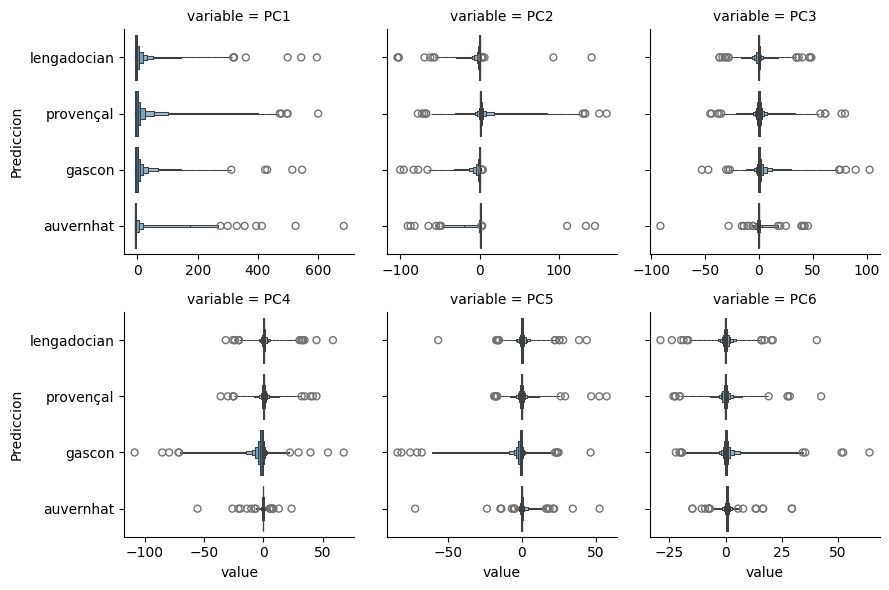

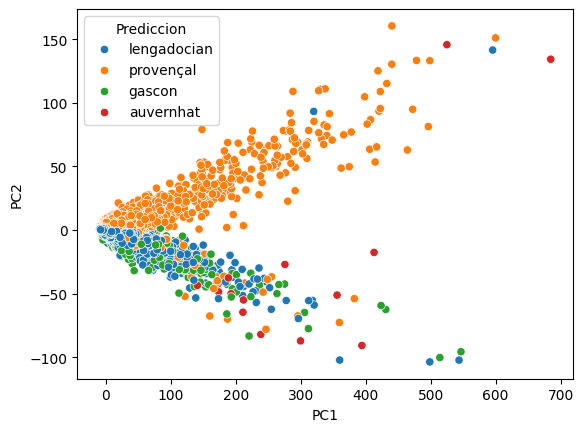

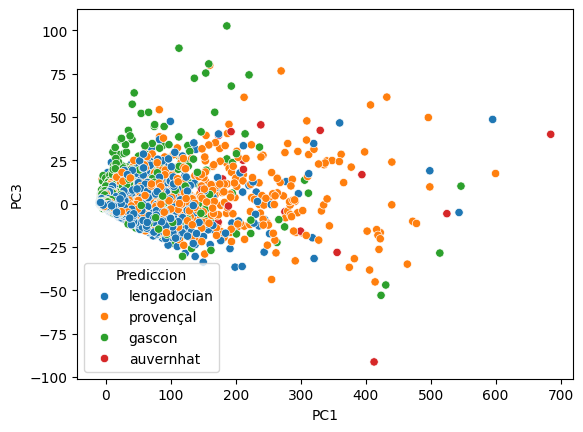

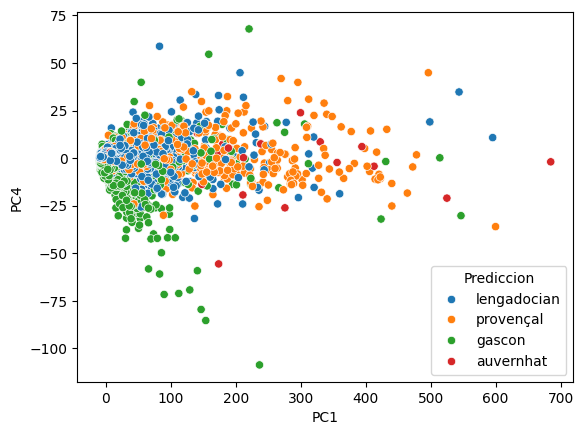

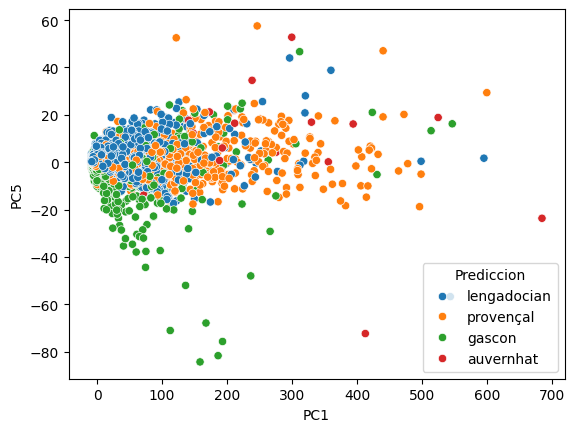

In [116]:
from sklearn.decomposition import PCA
tokens_importants = (fi_df["TokenIndex"].head(50)).to_list()

pca = PCA(n_components=6)
pca_out = pca.fit_transform(bow_tot[:,tokens_importants])
pca_df = pd.DataFrame(pca_out, columns=[f"PC{i+1}" for i in range(pca_out.shape[1])])
pca_df["Article"] = texte_df["Article"]
pca_df = pca_df.merge(resultats_df[["Article", "Prediccion"]], on="Article", how="left")
mlt_pca_df = pca_df.melt(id_vars=["Prediccion", "Article"])

g = sns.FacetGrid(data=mlt_pca_df, col="variable", col_wrap=3, sharex=False)
g.map_dataframe(sns.boxenplot, y="Prediccion", x="value")
plt.show()

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Prediccion")
plt.show()

sns.scatterplot(data=pca_df, x="PC1", y="PC3", hue="Prediccion")
plt.show()

sns.scatterplot(data=pca_df, x="PC1", y="PC4", hue="Prediccion")
plt.show()

sns.scatterplot(data=pca_df, x="PC1", y="PC5", hue="Prediccion")
plt.show()